C:\Users\jakob\AppData\Local\Temp\ipykernel_9100\3360190537.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ABKEl["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(ABKEl), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_9100\3360190537.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_9100\3360190537.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_ABK = ABKEl["ABKEl"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_9100\3360190537.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E = Spotpris["Spotpris"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykerne

Summa kostnad i el 2023: 12038866.640975235
De 30 högsta elförbrukningsvärdena och deras timmar i Excel-filen:
1. Timme 2023-03-23 16:00:00  - Förbrukning: 1693.0 (Excel rad: 8)
2. Timme 2023-03-25 16:00:00  - Förbrukning: 1692.744 (Excel rad: 9)
3. Timme 2023-03-24 16:00:00  - Förbrukning: 1640.544 (Excel rad: 10)
4. Timme 2023-04-07 17:00:00  - Förbrukning: 1627.0 (Excel rad: 11)
5. Timme 2023-04-12 17:00:00  - Förbrukning: 1611.0 (Excel rad: 12)
6. Timme 2023-03-26 16:00:00  - Förbrukning: 1601.216 (Excel rad: 13)
7. Timme 2023-04-01 17:00:00  - Förbrukning: 1594.0 (Excel rad: 14)
8. Timme 2023-03-31 16:00:00  - Förbrukning: 1587.656 (Excel rad: 15)
9. Timme 2023-03-25 17:00:00  - Förbrukning: 1586.0 (Excel rad: 16)
10. Timme 2023-03-30 16:00:00  - Förbrukning: 1575.416 (Excel rad: 17)
11. Timme 2023-03-24 17:00:00  - Förbrukning: 1571.0 (Excel rad: 18)
12. Timme 2023-03-30 17:00:00  - Förbrukning: 1570.0 (Excel rad: 19)
13. Timme 2023-03-27 16:00:00  - Förbrukning: 1560.736 (Excel 

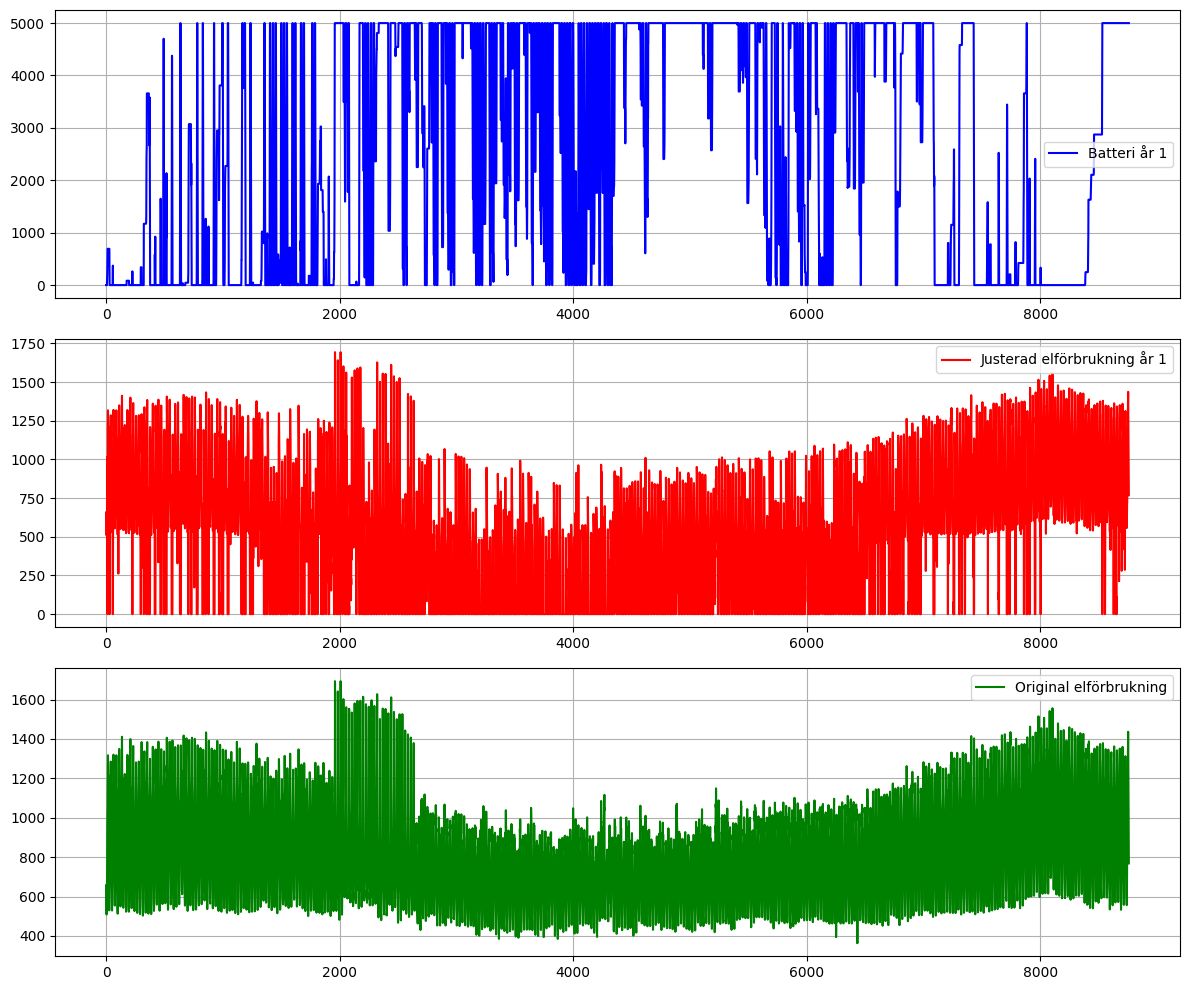

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Läs in Excel-filer
Solprod = pd.read_excel("SolprodABK.xlsx")
ABKEl = pd.read_excel("ABKEL.xlsx", names=["ABKEl"])
Spotpris = pd.read_excel("Spotpris.xlsx", names=["Spotpris"])  # Namnge kolumnen korrekt

# Extrahera första kolumnen från respektive DataFrame
Sol = 0.8*Solprod.iloc[:, 0]  # Solel-produktion multipliceras med faktor 0.8 eftersom hela takytan inte kan användas

# Konvertera Spotpris till en lista för iteration
Spot_list = Spotpris["Spotpris"].tolist()
ABK_list = ABKEl["ABKEl"].tolist()

# Skapa tidsindex för ABKEl och Spotpris
ABKEl["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(ABKEl), freq="H")
ABKEl.set_index("Tid", inplace=True)

Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
Spotpris.set_index("Tid", inplace=True)

# Resampla till månatligt genomsnitt
monthly_avg_ABK = ABKEl["ABKEl"].resample("M").mean()
monthly_avg_E = Spotpris["Spotpris"].resample("M").mean()

# Beräkna överföringsavgift per månad
Spotpris["E"] = 4.004 + 0.0613 * Spotpris["Spotpris"]
monthly_avg_E = Spotpris["E"].resample("M").mean()

# Beräkna summa överföringsavgift för hela året
summaÖverfAvgift = (monthly_avg_E * monthly_avg_ABK).sum()
fastAbbKostnad = 795180.4
summaElnätskostnadKR = (summaÖverfAvgift / 100) + fastAbbKostnad

Spot_array = np.array(Spot_list)
ABK_array = np.array(ABK_list)

elhandelskostnad = (Spot_array * ABK_array).sum() / 100
energiskatt = (43.9 * ABK_array).sum() / 100

summaElKostnad = (summaElnätskostnadKR + elhandelskostnad + energiskatt) * 1.25

print("Summa kostnad i el 2023:", summaElKostnad)



# ----------------------- YEAR 1 SIMULATION -----------------------
batteriKapacitet = 0.0  # Start with an empty battery
batteriMaxKapacitet = 5000  # Max battery capacity in kWh
maxFrånBatteri = 1500


elförbrukning = []  # Adjusted electricity consumption for Year 1
battery_values = []  # Battery energy over time
original_consumption = ABKEl["ABKEl"].tolist()
# Convert ABK to list for original consumption

köptaTimmar = []  # Lista för köpta spotpriser och tid

for tid, sol, abk, spot in zip(Spotpris.index, Sol, ABK_list, Spot_list):  
    diff = abk - sol  # Skillnad mellan förbrukning och solproduktion

    if diff < 0:  
        # Om solproduktionen är större än förbrukningen, ladda batteriet istället för att spara negativa värden
        batteriKapacitet = min(batteriKapacitet - diff, batteriMaxKapacitet)  # -diff eftersom diff är negativ
        elförbrukning.append(0)  # Vi behöver inte köpa el
        köptaTimmar.append((tid,0))
    else:
        if spot <= 35 and sol > 0:
            if batteriKapacitet + sol >= 5000: 
                solÖver = (batteriKapacitet + sol) - 5000
                batteriKapacitet = min(batteriKapacitet + sol, batteriMaxKapacitet)
                elförbrukning.append(max(0, abk-solÖver))  
                köptaTimmar.append((tid,spot))
            else:
                batteriKapacitet = min(batteriKapacitet + sol, batteriMaxKapacitet)
                elförbrukning.append(abk)  
                köptaTimmar.append((tid, spot)) 
        elif 35 < spot < 100 and sol > 0:
            elförbrukning.append(diff)
            köptaTimmar.append((tid, spot))
        elif spot >= 100:
            energiFrånBatteri = min(batteriKapacitet, diff, maxFrånBatteri)
            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, diff - energiFrånBatteri)
            elförbrukning.append(köpt_el)  
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
        else:
            elförbrukning.append(abk)  
            köptaTimmar.append((tid, spot))


    battery_values.append(batteriKapacitet)


# Konvertera elförbrukning till en NumPy-array
elförbrukning_array = np.array(elförbrukning)

# Hitta de 30 högsta värdena i elförbrukning
top_30_indices = np.argsort(elförbrukning_array)[-30:]  # Index för de 30 största värdena

# Hämta de faktiska tidsstämplarna från Spotpris.index
top_30_times = Spotpris.index[top_30_indices]

# Hämta de 30 största elförbrukningsvärdena
top_30_values = elförbrukning_array[top_30_indices]

# Sortera topp 30 i fallande ordning och behåll index
sorted_pairs = sorted(zip(top_30_values, top_30_times), reverse=True)

# Skriv ut de 30 högsta värdena tillsammans med originaltimmarna
print("De 30 högsta elförbrukningsvärdena och deras timmar i Excel-filen:")

for i, (value, original_time) in enumerate(sorted_pairs):
    excel_rad = i + 8  # +8 för rubrikrad och 1-baserade index, och +1 för att börja från 1
    print(f"{i+1}. Timme {original_time}  - Förbrukning: {value} (Excel rad: {excel_rad})")


# Fyll på elförbrukningen om den är kortare än Spotpris.index
if len(elförbrukning) < len(Spotpris.index):
    elförbrukning.extend([0] * (len(Spotpris.index) - len(elförbrukning)))


# Skapa DataFrame med tid som index
köptaTimmar_df = pd.DataFrame(köptaTimmar, columns=["Tid", "Spotpris"])
köptaTimmar_df.set_index("Tid", inplace=True)

# Beräkna månatligt medelvärde för köpta spotpriser
monthly_avg_E_köpt = köptaTimmar_df["Spotpris"].resample("M").mean()

# Skapa DataFrame för den uppdaterade elförbrukningen
elförbrukning_df = pd.DataFrame({"Tid": Spotpris.index, "elförbrukning": elförbrukning})
elförbrukning_df.set_index("Tid", inplace=True)

# Beräkna månatligt medelvärde av den uppdaterade elförbrukningen
monthly_avg_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").mean()

# Beräkna justerad överföringsavgift
summaJusteradÖverf = (monthly_avg_E_köpt * monthly_avg_elförbrukning).sum()

summaJusteradÖverfKR = (summaJusteradÖverf / 100) + fastAbbKostnad

# Filtrera elförbrukning endast för de köpta timmarna
elförbrukning_köpt = elförbrukning_df.loc[köptaTimmar_df.index]

# Beräkna elhandelskostnaden: Spotpris * elförbrukning
elhandelskostnad_köpt = (köptaTimmar_df["Spotpris"] * elförbrukning_köpt["elförbrukning"]).sum() / 100

# Beräkna den justerade energiskatten
total_elförbrukning = sum(elförbrukning)
JusteradEnergiskatt = (total_elförbrukning * 43.9) / 100

# Beräkna den justerade elkostnaden
summaJusteradElkostnad = 1.25 * (JusteradEnergiskatt + elhandelskostnad_köpt + summaJusteradÖverfKR)

print("Justerad elkostnad simulering:", summaJusteradElkostnad)

# ----------------------- PLOTTING RESULTS -----------------------
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

ax[0].plot(battery_values, label='Batteri år 1', color='blue')
ax[1].plot(elförbrukning, label='Justerad elförbrukning år 1', color='red')
ax[2].plot(original_consumption, label='Original elförbrukning', color='green')

for a in ax:
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()

